In [1]:
#first let us import the necessary modules

import matplotlib.pyplot as plt
from preprocessing import *
from ispy_utils import *
import numpy as np

In [2]:
#setting file paths

#precontrast image path
file_pre ='ispy_data/in/manifest-1724022411242/ISPY2/ISPY2-100899/10-26-2002-100899T0-ISPY2MRIT0-88595/500.000000-ISPY2 AX VIBRANT-SERIES-52523'

#postcontrast image path
file_post = 'ispy_data/in/manifest-1724022411242/ISPY2/ISPY2-100899/10-26-2002-100899T0-ISPY2MRIT0-88595/501.000000-ISPY2 Ph1AX VIBRANT-SERIES-03969'



(512, 512, 106)


(-0.5, 511.5, 511.5, -0.5)

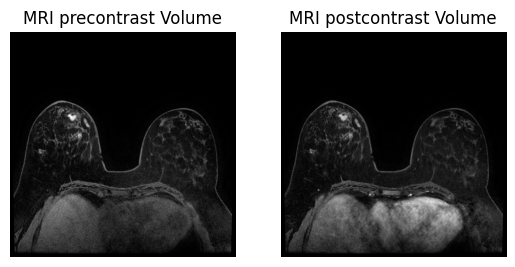

In [10]:
#apply function from ispymri.py 
image_array_pre, dcm_data_pre = read_precontrast_mri_ispy(file_pre)
# image_array_pre = zscore_image(normalize_image(image_array_pre))
# saving image - will be used as an input to prediction code
np.save('./input_pre/output.npy', image_array_pre)
print(image_array_pre.shape)  #optional

image_array_post, dcm_data_post = read_precontrast_mri_ispy(file_post)
# image_array_post = zscore_image(normalize_image(image_array_post))
np.save('./input_post/output.npy', image_array_post)


#plotting both the images

plt.subplot(1,2,1)
plt.title('MRI precontrast Volume')
plt.imshow(image_array_pre[:,:,41], cmap = 'gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title('MRI postcontrast Volume')
plt.imshow(image_array_post[:,:,41], cmap='gray')
plt.axis('off')


Below is the line of code that generates a breast mask

' ' ' 
python predict.py --target-tissue breast --image ./input_pre --save-masks-dir ./mask --model-save-path ./trained_models/breast_model.pth
' ' '

(512, 512, 106)


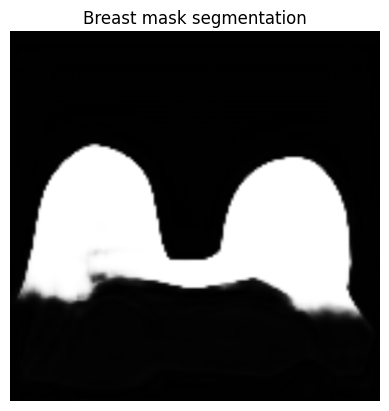

In [5]:
breast_mask_seg = np.load('./mask/output.npy')
print(breast_mask_seg.shape)

#plotting the mask
plt.imshow(breast_mask_seg[:, :, 41], cmap = 'gray')
plt.title('Breast mask segmentation')
plt.axis('off')
plt.show()

The line of code below runs fgt prediction for pre contrast and post contrast respectively

#pre contrast
python predict.py --target-tissue dv --image ./input_pre --input-mask ./mask --save-masks-dir ./fgt_pre --model-save-path ./trained_models/dv_model.pth

#post contrast
python predict.py --target-tissue dv --image ./input_post --input-mask ./mask --save-masks-dir ./fgt_post --model-save-path ./trained_models/dv_model.pth

(3, 512, 512, 106)


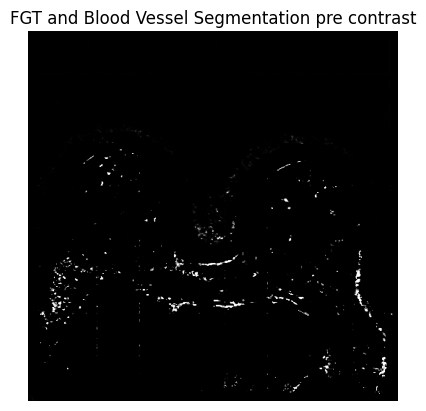

In [11]:
#shape of fgt
fgt_data_pre = np.load('./fgt_pre/output.npy')
print(fgt_data_pre.shape)

#plotting the data
plt.imshow(fgt_data_pre[0, :, :, 41], cmap = 'Greys')
plt.title('FGT and Blood Vessel Segmentation pre contrast')
plt.axis('off')
plt.show()

(3, 512, 512, 106)


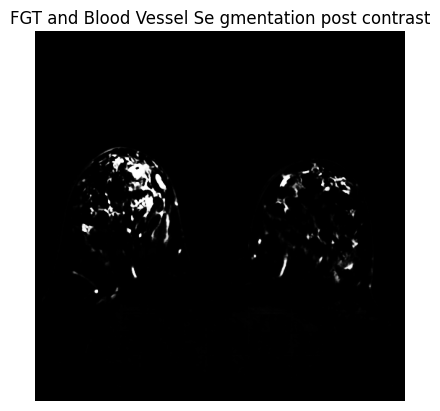

In [7]:
#shape of fgt
fgt_data_post = np.load('./fgt_post/output.npy')
print(fgt_data_post.shape)

#plotting the data
plt.imshow(fgt_data_post[0, :, :, 41], cmap = 'Greys')
plt.title('FGT and Blood Vessel Se gmentation post contrast')
plt.axis('off')
plt.show()